In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def calculate_eddy(width=500000, num_depth_layers=21, eta0=1, L=1e5, H=1000, a=1, b=1, rho0=1025, 
                                            f0=None, alpha_1=0., alpha_2=0., T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None):
    """
    Calculate the 3D geostrophic velocity components U, V, density anomaly sigma, temperature, salinity, 
    and pressure fields for an ocean eddy.

    Parameters:
    - width: Horizontal extent of the grid (eddy scale) in meters.
    - num_depth_layers: Number of vertical layers (depth resolution).
    - eta0: Surface elevation perturbation.
    - L: Horizontal length scale of the eddy in meters.
    - H: Vertical depth scale of the eddy in meters.
    - a, b: Coefficients affecting density anomaly variation.
    - rho0: Reference density (kg/m^3).
    - f0: Coriolis parameter. If None, it will be calculated based on a latitude of -34 degrees.
    - alpha_1, alpha_2: Coefficients affecting eddy center shift with depth.
    - T0: Surface temperature (degrees Celsius).
    - dTdz: Temperature gradient with depth (degrees Celsius per meter).
    - dSdz: Salinity gradient with depth (psu per meter).
    - taper_depth: Tapering scale for vertical variations.

    Returns:
    - U, V: 3D matrices for the U and V (x- and y-components) velocity fields.
    - sigma: 3D matrix for the density anomaly.
    - T: 3D matrix for the temperature field.
    - S: 3D matrix for the salinity field.
    - P: 3D matrix for the pressure field.
    - x, y, z: Horizontal and vertical grid points.
    """

    # Constants
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))  # Coriolis parameter for latitude -34 degrees
    g = 9.81  # Gravitational acceleration (m/s^2)

    # Create 2D meshgrid for horizontal space (x, y) and depth (z)
    x = np.linspace(-width // 2, width // 2, 101)  # x-coordinates
    y = np.linspace(-width // 2, width // 2, 101)  # y-coordinates
    z = np.linspace(-H, 0, num_depth_layers)  # Depth levels from surface (0) to -H

    # Create 3D meshgrid
    x_3d, y_3d, z_3d = np.meshgrid(x, y, z, indexing='ij')

    if taper_depth is None:
        taper_factor = np.ones_like(z_3d)
    else:
        taper_factor = np.exp(z_3d / taper_depth)

    # Define the functions f(|r - r_c(z)|) and g(z)
    def f_r_rc(r, L):
        return np.exp(-r**2 / L**2)

    # Calculate the center position as a function of depth
    x_c = alpha_1 * z_3d
    y_c = alpha_2 * z_3d

    # Calculate radial distance r - r_c(z)
    r_c = np.hypot( x_3d - x_c, y_3d - y_c )

    # Temperature field
    # T = T0 + dTdz * z_3d - 2 * f_r_rc(r_c, L) * taper_factor
    T = - 2 * f_r_rc(r_c, L) * taper_factor

    # Salinity field
    S0 = 35  # Reference surface salinity (psu)
    # S = S0 + dSdz * z_3d + 1.5 * f_r_rc(r_c, L) * taper_factor
    S = 1.5 * f_r_rc(r_c, L) * taper_factor

    # Pressure field (hydrostatic pressure)
    P = -rho0 * g * z_3d

    # Density field using a simplified equation of state
    alpha = 0.0002  # Thermal expansion coefficient (1/°C)
    beta = 0.0008  # Haline contraction coefficient (1/psu)
    sigma = rho0 * (1 - alpha * (T - T0) + beta * (S - S0)) 
    sigma -= np.mean(sigma)

    # Calculate geostrophic velocity components
    dx = x[1] - x[0]  # Grid spacing in x
    dy = y[1] - y[0]  # Grid spacing in y
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy

    U = g / f0 * d_sigma_dy * taper_factor
    V = -g / f0 * d_sigma_dx * taper_factor

    U = np.flip(U, axis=2)
    V = np.flip(V, axis=2)
    sigma = np.flip(sigma, axis=2)
    T = np.flip(T, axis=2)
    S = np.flip(S, axis=2)
    P = np.flip(P, axis=2)
    z = np.flip(z)

    return U, V, sigma, T, S, P, x, y, z


In [3]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=None)

U_tap, V_tap, sigma_tap, T_tap, S_tap, P_tap, _, _, _ = calculate_eddy(taper_depth=400)

dx, dy, dz = x[1] - x[0], y[1] - y[0], z[1]-z[0]

alpha_1 = dx / dz # tilt in x direction

U_tilt, V_tilt, sigma_tilt, T_tilt, S_tilt, P_tilt, _, _, _ = calculate_eddy(taper_depth=None, alpha_1=alpha_1)

U_tilt_tap, V_tilt_tap, sigma_tilt_tap, T_tilt_tap, S_tilt_tap, P_tilt_tap, _, _, _ = calculate_eddy(taper_depth=400, alpha_1=alpha_1)


In [4]:
modelled_data = {
    'Eddy0':{
        'Name': 'E1', 'U': U, 'V': V, 'sigma': sigma, 'T': T, 'S': S, 'P': P
    },
    'Eddy1':{
        'Name': r'E1$_\text{tap}$', 'U': U_tap, 'V': V_tap, 'sigma': sigma_tap, 'T': T_tap, 'S': S_tap, 'P': P_tap
    },
    'Eddy2':{
        'Name': 'E2', 'U': U_tilt, 'V': V_tilt, 'sigma': sigma_tilt, 'T': T_tilt, 'S': S_tilt, 'P': P_tilt
    },
    'Eddy3':{
        'Name': r'E2$_\text{tap}$', 'U': U_tilt_tap, 'V': V_tilt_tap, 'sigma': sigma_tilt_tap, 'T': T_tilt_tap, 'S': S_tilt_tap, 'P': P_tilt_tap
    },
    'x': x, 'y': y, 'z': z
}
eddies = ['Eddy0', 'Eddy1', 'Eddy2', 'Eddy3']

In [19]:
result_data = pd.DataFrame(columns=['Eddy', 'z', 'xc', 'yc', 'Depth', 'Vort'])

x, y = modelled_data['x'], modelled_data['y']
X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]

for eddy in eddies:
    
    U, V = modelled_data[eddy]['U'], modelled_data[eddy]['V']
    xc_pre, yc_pre = 0, 0

    for depth_lvl in range(U.shape[-1]):

        # Find nencioli
        u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]
        
        # Fit cubic and tangent
        def fit_cubic_and_tangent(x, y):
            cubic = np.poly1d(np.polyfit(x, y, 3))
            cubic_deriv = np.polyder(cubic)
            roots = np.roots(cubic)
            valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
        
            if valid_roots.size:
                R = np.abs(valid_roots-x[len(x)//2])
                root = valid_roots[R==np.min(R)][0]
                slope = cubic_deriv(root)
                intercept = -slope * root
            else:
                slope = 0
                roots = np.roots(cubic_deriv)
                valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
                if valid_roots.size:
                    R = np.abs(valid_roots-x[len(x)//2])
                    root = valid_roots[R==np.min(R)]
                    intercept = cubic(root)
                else:
                    intercept = np.mean(y)
        
            tangent_line = slope * x + intercept
            sst = np.sum((y - np.mean(y))**2)
            sse = np.sum((y - tangent_line)**2)
            
            if sst == 0 and sse == 0:
                r_squared = 1
            else:
                r_squared = 1 - (sse / sst)
                
            return slope, intercept, r_squared
        
        # Plot fits
        def extend_indices(arr, start_idx, r):
            indices = [start_idx]
            idx = start_idx
            i = 0
            while idx > 0 and not np.isnan(arr[idx - 1]):
                idx -= 1
                indices.insert(0, idx)
                if i > r:
                    break
                i += 1
            idx = start_idx
            i = 0
            while idx < len(arr) - 1 and not np.isnan(arr[idx + 1]):
                idx += 1
                indices.append(idx)
                if i > r:
                    break
                i += 1
            return indices

        nic, njc = u.shape[0] // 2, u.shape[1] // 2
        
        r = 40 # 
        indices_1 = extend_indices(u[:, njc], nic, r)
        indices_2 = extend_indices(u[nic, :], njc, r)
        u1 = u[indices_1, njc]
        v1 = v[indices_1, njc]
        u2 = u[nic, indices_2]
        v2 = v[nic, indices_2]
        xx = x[indices_1] / 1000
        yy = y[indices_2] / 1000
                    
        # Calculate results
        A1, A0, r2A = fit_cubic_and_tangent(xx, u1)
        B1, B0, r2B = fit_cubic_and_tangent(xx, v1)
        C1, C0, r2C = fit_cubic_and_tangent(yy, u2)
        D1, D0, r2D = fit_cubic_and_tangent(yy, v2)
        
        alpha = A0 if r2A < r2B else C0
        beta = B0 if r2B < r2D else D0
        gamma = A1 if r2A < r2D else -D1
        q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
                    
        yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))
        xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))
        w = 2 * (q11 + q22)

        xc_pre, yc_pre = xc, yc

        R = np.hypot(xc - xc_pre, yc - yc_pre)
        if R < 100000:

            result_data.loc[len(result_data)] = {
                'Eddy': eddy,
                'z': depth_lvl,
                'xc': xc,
                'yc': yc,
                'Depth': z[depth_lvl],
                'Vort': w
            }
        else:
            break

In [29]:
df

,xc,yc,Depth,Vort
z,,,,
0,8.349411e-15,8.349411e-15,0.0,-0.037999
1,1.603745e+01,1.407959e+00,-50.0,-0.029516
2,3.286815e+01,5.771188e+00,-100.0,-0.022806
3,5.142097e+01,-1.354349e+01,-150.0,-0.017529
4,7.294665e+01,2.561811e+01,-200.0,-0.013403
5,9.933973e+01,4.361049e+01,-250.0,-0.010194
6,1.337910e+02,7.048490e+01,-300.0,-0.007715
7,1.823076e+02,1.120583e+02,-350.0,-0.005809
8,2.578840e+02,-1.811686e+02,-400.0,-0.004354


In [68]:
def vis(eddy, depth_lvl):
    
    U, V = modelled_data[eddy]['U'], modelled_data[eddy]['V']
    x, y = modelled_data['x'], modelled_data['y']
    
    # Find nencioli
    u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]

    nic, njc = u.shape[0] // 2, u.shape[1] // 2
    
    # Fit cubic and tangent
    def fit_cubic_and_tangent(x, y):
        cubic = np.poly1d(np.polyfit(x, y, 3))
        cubic_deriv = np.polyder(cubic)
        roots = np.roots(cubic)
        valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
    
        if valid_roots.size:
            R = np.abs(valid_roots-x[len(x)//2])
            root = valid_roots[R==np.min(R)]
            slope = cubic_deriv(root)
            intercept = -slope * root
        else:
            slope = 0
            roots = np.roots(cubic_deriv)
            valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
            if valid_roots.size:
                R = np.abs(valid_roots-x[len(x)//2])
                root = valid_roots[R==np.min(R)]
                intercept = cubic(root)
            else:
                intercept = np.mean(y)
    
        tangent_line = slope * x + intercept
        sst = np.sum((y - np.mean(y))**2)
        sse = np.sum((y - tangent_line)**2)
        if sst == 0 and sse == 0:
            r_squared = 1
        else:
            r_squared = 1 - (sse / sst)

        return slope, intercept, r_squared
    
    # Plot fits
    def extend_indices(arr, start_idx, r):
        indices = [start_idx]
        idx = start_idx
        i = 0
        while idx > 0 and not np.isnan(arr[idx - 1]):
            idx -= 1
            indices.insert(0, idx)
            if i > r:
                break
            i += 1
        idx = start_idx
        i = 0
        while idx < len(arr) - 1 and not np.isnan(arr[idx + 1]):
            idx += 1
            indices.append(idx)
            if i > r:
                break
            i += 1
        return indices
    
    r = 20 # 
    indices_1 = extend_indices(u[:, njc], nic, r)
    indices_2 = extend_indices(u[nic, :], njc, r)
    u1 = u[indices_1, njc]
    v1 = v[indices_1, njc]
    u2 = u[nic, indices_2]
    v2 = v[nic, indices_2]
    xx = x[indices_1] / 1000
    yy = y[indices_2] / 1000
    
    fig, axs = plt.subplots(1, 4, figsize=(28, 7))
    datasets = [(xx, u1, 'u1'),
                (xx, v1, 'v1'),
                (yy, u2, 'u2'),
                (yy, v2, 'v2')]
    
    for ax, (l, vel, label) in zip(axs, datasets):
        slope, intercept, r2 = fit_cubic_and_tangent(l, vel)
        l_fine = np.linspace(l.min(), l.max(), 500)
        ax.plot(l, vel, 'o', label=f'Original {label} data')
        ax.plot(l_fine, np.poly1d(np.polyfit(l, vel, 3))(l_fine), '-', label=f'Cubic fit for {label}')
        ax.plot(l_fine, slope * l_fine + intercept, '--', label=f'R2={r2:.2f}')
        ax.axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=.5)
        ax.set_xlabel('x' if '1' in label else 'y')
        ax.set_ylabel(label)
        ax.legend()
    plt.tight_layout()
    plt.show()
    
    A1, A0, r2A = fit_cubic_and_tangent(xx, u1)
    B1, B0, r2B = fit_cubic_and_tangent(xx, v1)
    C1, C0, r2C = fit_cubic_and_tangent(yy, u2)
    D1, D0, r2D = fit_cubic_and_tangent(yy, v2)
    
    alpha = A0 if r2A < r2B else C0
    beta = B0 if r2B < r2D else D0
    gamma = A1 if r2A < r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
    
    yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))  
    xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))      
    w = 2 * (q11 + q22)
    
    # Plot results
    spacing = 5
    plt.quiver(X[::spacing, ::spacing]/1000, Y[::spacing, ::spacing]/1000, u[::spacing, ::spacing].T, v[::spacing, ::spacing].T)

    plt.plot(xx, [0]*len(xx), 'r', zorder=1, alpha=.5)
    plt.plot([0]*len(yy), yy, 'r', zorder=1, alpha=.5)

    plt.scatter(xc, yc, color='r', marker='x', s=100, label='MOCA')
    plt.legend()
    print(xc, yc)

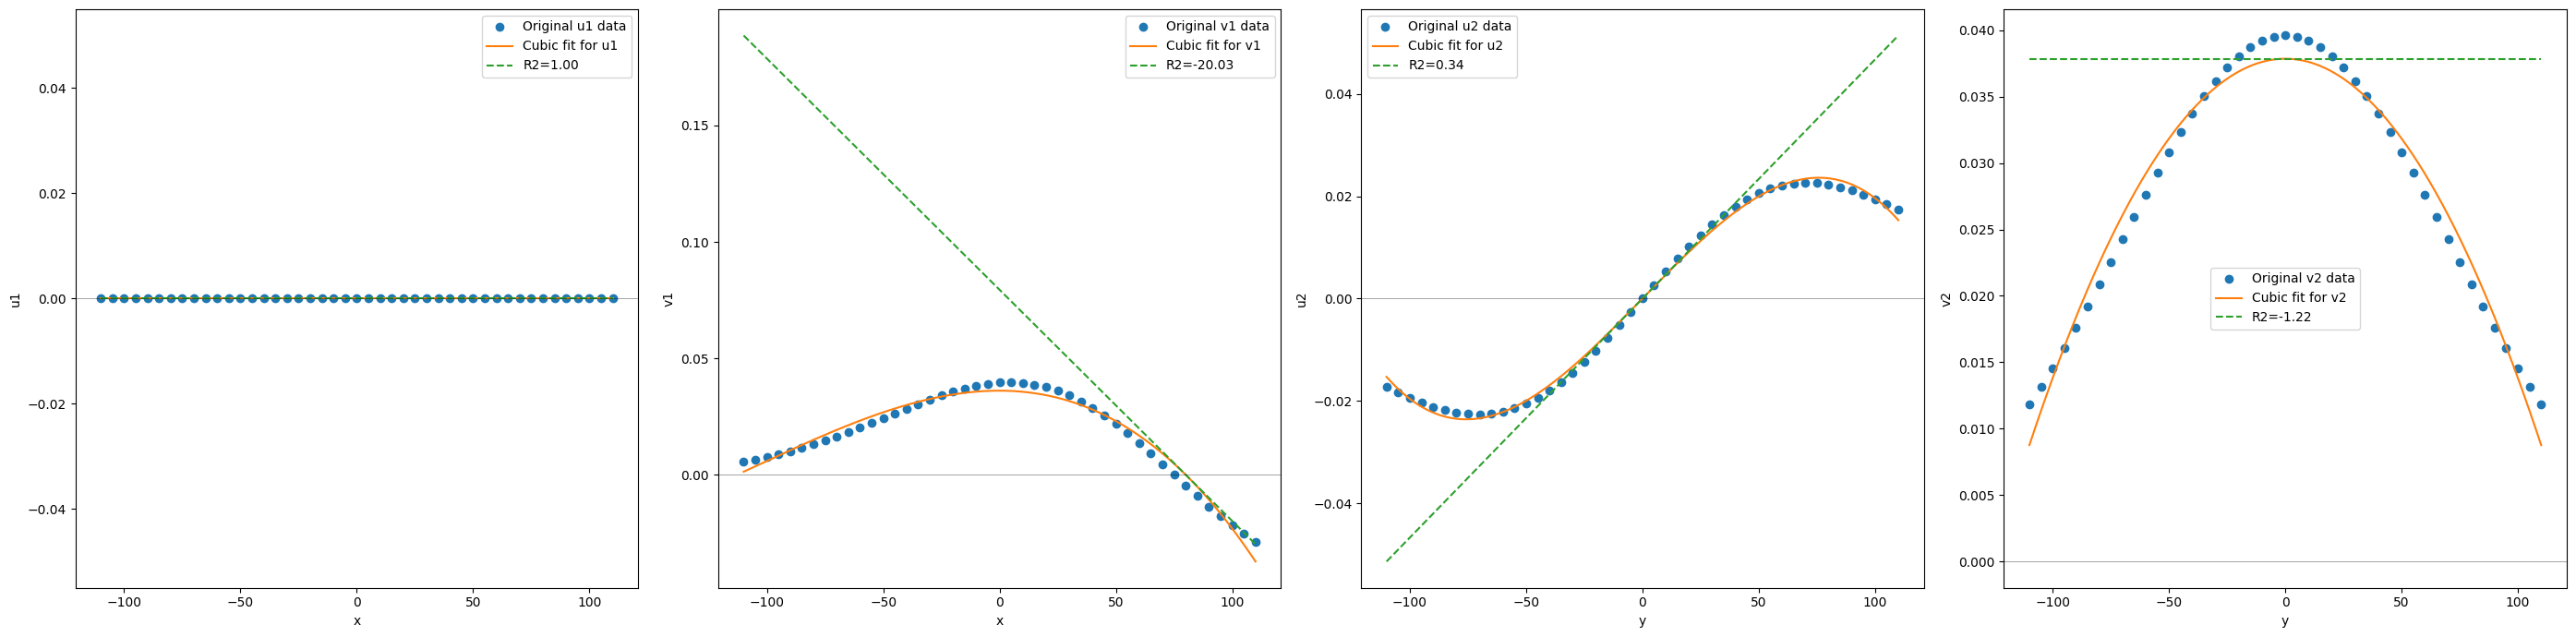

[80.03983385] [1.03799104e-15]


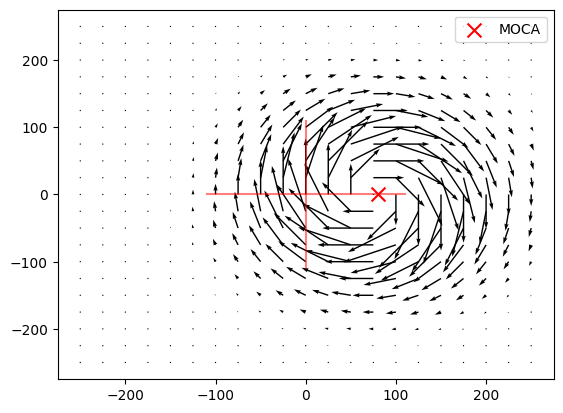

In [70]:
vis('Eddy3', 15)